# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

In this assignment I perform,
 
1. Data reading
2. Exploratory Data Analysis
3. Text Preprocessing on Review text data and Summary data
4. Sample data from dataset and split into Train and Test data

Next I apply RBF SVM on all Featurizations

5. Perform Featurizations - BoW, TF-IDF, Avg W2V, TFIDF-W2V
6. Apply RBF Kernel using SVC on all 4 featurizations, Bow, TFIDF, AVGW2V, TFIDF-W2V .
7. Feature Importance on BoW and TFIDF.
8. Tabulate the results


# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


In [3]:

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [4]:
# Loading the data
# using SQLite Table to read data.
con = sqlite3.connect('I:\Python\database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(5)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is necessary to remove duplicates in order to get unbiased results for the analysis of the data. Hence in order to reduce redundancy it's better to eliminate the rows that have same parameters.

The method used to perform deduplication is that, we first sort the data according to ProductId and then just keep the first similar product review and delete the others. This method ensures that there is only one representative for each product.

In [5]:
#Sorting data according to ProductId in ascending order
sorted_data = filtered_data.sort_values('ProductId', axis = 0, ascending = True, inplace = False, kind = 'quicksort', na_position = 'last')

#Dropping duplicates. It says that find duplicates with {'UserId', 'ProfileName', 'Time', 'Text'} values same. Then it is a duplicate
# By using drop_duplicate function we just keep the first product Id of the duplicates and remove the remaining.
final_data = sorted_data.drop_duplicates(subset = {'UserId', 'ProfileName', 'Time', 'Text'}, keep = 'first', inplace = False)

# Now it prints total reviews after removing duplicates.
print('Total number of reviews in the dataframe after removing duplicated:', final_data.shape)


Total number of reviews in the dataframe after removing duplicated: (364173, 10)


In [6]:
# HelpfulnessNumerator should always be less than HelpfulnessDenominator. 
# So check if any reviews have HelpfulnessNumerator greater than HelpfulnessDenominator and remove them

final_data = final_data[final_data.HelpfulnessNumerator <= final_data.HelpfulnessDenominator]
final_data.shape

(364171, 10)

In [7]:
#Checking to see how much % of data still remains
(final_data['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25852107399194

In [8]:
# Lets see how many total reviews left
print(final_data.shape)

#How many positive and negative reviews are present in the dataset?
final_data['Score'].value_counts()


(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#### Observation:-
From the above output we can see that there are many positive reviews and fewer negative reviews.

#  [3] Text  Preprocessing

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis.

1. By removing stop-words, BoW vector will be small and more meaningful
2. Lemmatization is a process of breaking a sentence into words. It is language and context dependent

Hence in the Preprocessing phase we do the following in the order below:-

1. Remove all URL's
2. Remove all tags from the strings
3. Expanding English language contractions like, you've -> you have
4. Remove any punctuations or limited set of special characters like , or . or # etc.
5. Check if the word is made up of english letters and is not alpha-numeric
6. Remove words with numbers
7. Remove spacial characters
8. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
9. Convert the words to lowercase
10. Remove Stopwords
11. Finally Stemming the words which are related, to their stem form/root/base form (Snowball stemmer is used as it is obsereved to be better than Porter Stemming)

After which we collect the words used to describe positive and negative reviews

## [3.1].  Preprocessing Review Text

In [9]:
# printing some random reviews
sent_5 = final_data['Text'].values[5]
print(sent_5)
print("="*50)

sent_60000 = final_data['Text'].values[60000]
print(sent_60000)
print("="*50)

sent_15500 = final_data['Text'].values[15500]
print(sent_15500)
print("="*50)

sent_4900 = final_data['Text'].values[4900]
print(sent_4900)
print("="*50)

A charming, rhyming book that describes the circumstances under which you eat (or don't) chicken soup with rice, month-by-month. This sounds like the kind of thing kids would make up while they're out of recess and sing over and over until they drive the teachers crazy. It's cute and catchy and sounds really childlike but is skillfully written.
<a href="http://www.amazon.com/gp/product/B000F4D5WG">Edward & Sons Organic Croutons, Italian Herbs, 5.25-Ounce Packs (Pack of 6)</a><br /><br />Knowing that I have to watch my calories I have been eating nothing but low cal foods for quite a while.  Part of my diet consists of big salads and low fat Progresso soups. I wanted something extra that I could add to a salad  and/or a soup.  I decided to try these.  They are extremely salty and aside from that have no other taste.  I would not re order these again.  I do admit that I do not care for salty foods but if salt is used the taste of it should not be so overwhelming. Some foods are understan

In [10]:
# Remove urls from text ----  https://stackoverflow.com/a/40823105/4084039
import re
sent_5 = re.sub(r"http\S+", "", sent_5)
sent_60000 = re.sub(r"http\S+", "", sent_60000)
sent_15500 = re.sub(r"http\S+", "", sent_15500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_60000)

<a href=" & Sons Organic Croutons, Italian Herbs, 5.25-Ounce Packs (Pack of 6)</a><br /><br />Knowing that I have to watch my calories I have been eating nothing but low cal foods for quite a while.  Part of my diet consists of big salads and low fat Progresso soups. I wanted something extra that I could add to a salad  and/or a soup.  I decided to try these.  They are extremely salty and aside from that have no other taste.  I would not re order these again.  I do admit that I do not care for salty foods but if salt is used the taste of it should not be so overwhelming. Some foods are understandably noted for being salty, anchovies, pretzels etc. I do eat pretzels and like them as long as I don't feel as if I put several tablespoons of salt in my mouth. I do not taste any of the herbs that I expected in a product which claims to have as one of it's ingredients Italian herbs.


In [11]:
# Removes all tags from a string --- https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element

from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_5, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_15500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

A charming, rhyming book that describes the circumstances under which you eat (or don't) chicken soup with rice, month-by-month. This sounds like the kind of thing kids would make up while they're out of recess and sing over and over until they drive the teachers crazy. It's cute and catchy and sounds really childlike but is skillfully written.
I use this exclusively in all my cooking...I don't understand why the price went up so drastically...I have many of the ladies I work with that are hooked on this product and they want me to get them more
Can't do sugar.  Have tried scores of SF Syrups.  NONE of them can touch the excellence of this product.Thick, delicious.  Perfect.  3 ingredients: Water, Maltitol, Natural Maple Flavor.  PERIOD.  No chemicals.  No garbage.Have numerous friends & family members hooked on this stuff.  My husband & son, who do NOT like "sugar free" prefer this over major label regular syrup.I use this as my SWEETENER in baking: cheesecakes, white brownies, muffin

In [12]:
# Expanding English language contractions  like, you've -> you have,  aren't -> are not
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [13]:
sent_5 = decontracted(sent_5)
print(sent_5)
print("="*50)

A charming, rhyming book that describes the circumstances under which you eat (or do not) chicken soup with rice, month-by-month. This sounds like the kind of thing kids would make up while they are out of recess and sing over and over until they drive the teachers crazy. It is cute and catchy and sounds really childlike but is skillfully written.


In [14]:
# Removes punctuations from strings ---  https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string-in-python
sent_5 = re.sub(r"http\S+", "", sent_5)
sent_60000 = re.sub(r'[^\w\s]','', sent_60000)
sent_15500 = re.sub(r'[^\w\s]','', sent_15500)
sent_4900 = re.sub(r'[^\w\s]','', sent_4900)

print(sent_60000)

a href  Sons Organic Croutons Italian Herbs 525Ounce Packs Pack of 6abr br Knowing that I have to watch my calories I have been eating nothing but low cal foods for quite a while  Part of my diet consists of big salads and low fat Progresso soups I wanted something extra that I could add to a salad  andor a soup  I decided to try these  They are extremely salty and aside from that have no other taste  I would not re order these again  I do admit that I do not care for salty foods but if salt is used the taste of it should not be so overwhelming Some foods are understandably noted for being salty anchovies pretzels etc I do eat pretzels and like them as long as I dont feel as if I put several tablespoons of salt in my mouth I do not taste any of the herbs that I expected in a product which claims to have as one of its ingredients Italian herbs


In [15]:
#remove words with numbers --- https://stackoverflow.com/a/18082370/4084039
sent_60000 = re.sub("\S*\d\S*", "", sent_60000).strip()
print(sent_60000)

a href  Sons Organic Croutons Italian Herbs  Packs Pack of  br Knowing that I have to watch my calories I have been eating nothing but low cal foods for quite a while  Part of my diet consists of big salads and low fat Progresso soups I wanted something extra that I could add to a salad  andor a soup  I decided to try these  They are extremely salty and aside from that have no other taste  I would not re order these again  I do admit that I do not care for salty foods but if salt is used the taste of it should not be so overwhelming Some foods are understandably noted for being salty anchovies pretzels etc I do eat pretzels and like them as long as I dont feel as if I put several tablespoons of salt in my mouth I do not taste any of the herbs that I expected in a product which claims to have as one of its ingredients Italian herbs


In [16]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_4900 = re.sub('[^A-Za-z0-9]+', ' ', sent_4900)
print(sent_4900)

Cant do sugar Have tried scores of SF Syrups NONE of them can touch the excellence of this productbr br Thick delicious Perfect 3 ingredients Water Maltitol Natural Maple Flavor PERIOD No chemicals No garbagebr br Have numerous friends family members hooked on this stuff My husband son who do NOT like sugar free prefer this over major label regular syrupbr br I use this as my SWEETENER in baking cheesecakes white brownies muffins pumpkin pies etc Unbelievably deliciousbr br Can you tell I like it 


In [17]:
# Converting words into lowercase
sent_4900 = sent_4900.lower()
print(sent_4900)

cant do sugar have tried scores of sf syrups none of them can touch the excellence of this productbr br thick delicious perfect 3 ingredients water maltitol natural maple flavor period no chemicals no garbagebr br have numerous friends family members hooked on this stuff my husband son who do not like sugar free prefer this over major label regular syrupbr br i use this as my sweetener in baking cheesecakes white brownies muffins pumpkin pies etc unbelievably deliciousbr br can you tell i like it 


In [18]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [19]:
# Combining all the above stundents 
from tqdm import tqdm
final_strings = []
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
# tqdm is for printing the status bar
for sentence in tqdm(final_data['Text'].values):
    sentence = re.sub(r"http\S+", "", sentence)  # To remove urls from text
    sentence = BeautifulSoup(sentence, 'lxml').get_text() # To remove all tags from an element
    sentence = decontracted(sentence) # Expanding English language contractions  like, you've -> you have,  aren't -> are not
    sentence = re.sub(r'[^\w\s]','', sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip() # removes words with numbers
    sentence = re.sub('[^A-Za-z]+', ' ', sentence) # removes special characters
    sentence = sentence.lower()  # Converting words into lowercase
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    final_strings.append(sentence.strip())

100%|██████████| 364171/364171 [02:51<00:00, 2121.72it/s]


In [20]:
final_strings[55000]

'great product anyone would love even not gluten free great servicefast'

In [21]:
# store final_data table into an SQlLite table for future.
conn = sqlite3.connect('final_data.sqlite')
c=conn.cursor()
conn.text_factory = str
final_data.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)


In [27]:
final_data['CleanedText'] = final_strings
final_data.shape
final_data.head(3)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew reading sendak books watching really rosi...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...


In [28]:
print(final_data['Score'].value_counts())

1    307061
0     57110
Name: Score, dtype: int64


## [3.2]  Preprocessing Reviews Summary

In [29]:
# printing some random reviews
sent_6 = final_data['Text'].values[6]
print(sent_6)
print("="*50)

sent_5000 = final_data['Text'].values[5000]
print(sent_5000)
print("="*50)

sent_50000 = final_data['Text'].values[50000]
print(sent_50000)
print("="*50)

sent_355000 = final_data['Text'].values[355000]
print(sent_355000)
print("="*50)

I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.
late delivered, I paid extra charge for faster delivery but is not delivered on the time i've expected it.
We use marinade on a weekly basis, and this is another flavor from Lawry's that is really good.  Not too spicy or overwhelming, making it a good marinade for everyone (even picky kids who don't like spicy tastes).
Great taste and amazing crunch. If you have never experienced the large/deluxe/fancy peanuts and have only had 

In [30]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_6, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_5000, 'lxml')
text= soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_50000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_355000, 'lxml')
text = soup.get_text()
print(text)

I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.First, this book taught him the months of the year.Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.
late delivered, I paid extra charge for faster delivery but is not delivered on the time i've expected it.
We use marinade on a weekly basis, and this is another flavor from Lawry's that is really good.  Not too spicy or overwhelming, making it a good marinade for everyone (even picky kids who don't like spicy tastes).
Great taste and amazing crunch. If you have never experienced the large/deluxe/fancy peanuts and have only had Planters or regular "salted in the s

In [31]:
# Expanding English language contractions  like, you've -> you have,  aren't -> are not
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [32]:
sent_5000 = decontracted(sent_5000)
print(sent_5000)
print("="*50)

late delivered, I paid extra charge for faster delivery but is not delivered on the time i have expected it.


In [33]:
#remove words with numbers ---- https://stackoverflow.com/a/18082370/4084039
sent_6 = re.sub("\S*\d\S*", "", sent_6).strip()
print(sent_6)

I set aside at least an hour each day to read to my son  y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to  y/o old to  /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [34]:
#remove spacial character ----- https://stackoverflow.com/a/5843547/4084039
sent_355000 = re.sub('[^A-Za-z0-9]+', ' ', sent_355000)
print(sent_355000)

Great taste and amazing crunch If you have never experienced the large deluxe fancy peanuts and have only had Planters or regular salted in the shell you are in for a wonderful experience The intense taste and solid crunch will keep your hand in the can til they are gone 


In [35]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [36]:
# Performing all the preprocessing steps on Summary data.
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"
from tqdm import tqdm
summary_data = []
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
# tqdm is for printing the status bar
for sentence in tqdm(final_data['Summary'].values):
    sentence = re.sub(r"http\S+", "", sentence)  # To remove urls from text
    sentence = BeautifulSoup(sentence, 'lxml').get_text() # To remove all tags from an element
    sentence = decontracted(sentence) # Expanding English language contractions  like, you've -> you have,  aren't -> are not
    sentence = re.sub(r'[^\w\s]','', sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip() # removes words with numbers
    sentence = re.sub('[^A-Za-z]+', ' ', sentence) # removes special characters
    sentence = sentence.lower()  # Converting words into lowercase
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    summary_data.append(sentence.strip())

100%|██████████| 364171/364171 [02:15<00:00, 2686.72it/s]


In [37]:
summary_data[56000]

'awesome yummy'

In [38]:
# store final_data table into an SQlLite table for future.
conn = sqlite3.connect('final_data.sqlite')
c=conn.cursor()
conn.text_factory = str
final_data.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)


In [39]:
final_data['CleanedSummary'] = summary_data 
final_data.shape
final_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedSummary
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...,every book educational
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew reading sendak books watching really rosi...,love book miss hard cover version
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...,chicken soup rice months


In [40]:
print(final_data['Score'].value_counts())

1    307061
0     57110
Name: Score, dtype: int64


# 4. Sample the data from the Dataset

## [4.1]  Time Based Splitting

Generally we do random splitting of entire dataset into train, test, cross validate data. With this method we may not get correct accuracy everytime. With time products change and reviews for the product also change, hence with random splitting we may not get best value/accuracy.

But for Amazon Food Reviews Dataset Time based splitting is better than Random splittng. We can perform Time based splitting only when we have time feature in our dataset. Cross Validate data is used to find best hyper parameter and Test data is used to find accuracy and we train a model on all these.

So Time based splitting gives more accuracy than random splitting, even on the future data when data changes with time. It's preferable to do Time based splitting when time is available.

1. For each review in the dataset there is a timestamp. In Time based splitting, we first sort all the data in the dataset in increasing order(ascending) of time.
2. Now split 70% of data into Train data and remaining 30% of data into test data.


In [41]:
# sorting data using time
final_data['Time'] = pd.to_datetime(final_data['Time'])
final_data = final_data.sort_values(by = 'Time', ascending = True)


In [42]:
# display top 5 rows
final_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedSummary
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1970-01-01 00:00:00.939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...,every book educational
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1970-01-01 00:00:00.940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,remember seeing show aired television years ag...,whole series great way spend time child
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,1970-01-01 00:00:00.944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuice well written movie everything exce...,entertainingl funny


### Sample the data from the Dataset

In [56]:
# taking top 10000 data points due to computational issues and computation time for RBF kernel is taking very long 
# more than 24hrs in my laptop. Please consider it.

total_score = final_data.iloc[:10000,:]
print(total_score.shape)
print(total_score['Score'].value_counts())

(10000, 12)
1    8868
0    1132
Name: Score, dtype: int64


## [4.2] Splitting data into Train and Test data

In [57]:
# splitting the data into train, test data
from sklearn.cross_validation import train_test_split
X = total_score['CleanedText']
Y = total_score['Score']
# X = total data, Y = class labels, X_test and Y_test are test data set of 30%
# Total score is splitted into Train and test data with 70-30 ratio

X_train_rbf, X_test_rbf, Y_train_rbf, Y_test_rbf = train_test_split(X, Y, test_size=0.3, random_state=0)

print('X_train_rbf, Y_train_rbf', X_train_rbf.shape, Y_train_rbf.shape)
print('X_test_rbf, Y_test_rbf', X_test_rbf.shape, Y_test_rbf.shape)

X_train_rbf, Y_train_rbf (7000,) (7000,)
X_test_rbf, Y_test_rbf (3000,) (3000,)


# [5] Featurizations

## 5.1 BoW for RBF Kernel

In [58]:
# BoW for 10k sample data for RBF kernel
# Creating a variable count_vect of CountVectorizer type and inititalizing it.
# min_df is used for removing terms that appear too infrequently/ less frequently
# min_df = 10 means "ignore terms that appear in less than 10 documents
# max_features - It considers the top max_features ordered by term frequency across the corpus.

count_vect = CountVectorizer(min_df = 10, max_features = 500) #in scikit-learn

# X_train_rbf and X_test_rbf data is converted vector and is stored in X_train_rbf_bow and X_test_rbf_bow
X_train_rbf_bow = count_vect.fit_transform(X_train_rbf)
X_test_rbf_bow = count_vect.transform(X_test_rbf)

# sparse matrix - most of the values of any row in a matrix are zero.Such matrices are called sparse matrix and row in the matrix is sparse vector
# The more sparse a matrix is, the more efficient is sparse matrix representation technique
print("the type of count vectorizer ", type(X_train_rbf_bow))# gets the type of X_train_rbf_bow which is a matrix
print("the type of count vectorizer ", type(X_test_rbf_bow))# gets the type of X_test_rbf_bow which is a matrix

# gets the shape of the matrix
print(X_train_rbf_bow.get_shape()) 
print(X_test_rbf_bow.get_shape()) 

print("the number of unique words are ", X_train_rbf_bow.get_shape()[1])
print("the number of unique words are ", X_test_rbf_bow.get_shape()[1])


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
(7000, 500)
(3000, 500)
the number of unique words are  500
the number of unique words are  500


### Standardizing the data

In [59]:
from sklearn.preprocessing import StandardScaler
# Standardize the data
scalar = StandardScaler(with_mean=False)
X_train_rbf_bow_std = scalar.fit_transform(X_train_rbf_bow)
X_test_rbf_bow_std = scalar.transform(X_test_rbf_bow)

print("Final shape of matrix", X_train_rbf_bow_std.shape)
print("Final shape of matrix", X_test_rbf_bow_std.shape)

Final shape of matrix (7000, 500)
Final shape of matrix (3000, 500)


# RBF Kernel

##  5.2  Applying GridSearchCV and RBF Kernel on BoW using AUC-score as metric 

In [61]:
# Implementing RBF Kernel.
# C and gamma are the hyperparameters for RBF Kernel. gamma = 1/sigma
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# GridsearchCV trains the model on these parmters to find the best one
# List of parameters for hyperparameter tuning
# 'gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

tuned_parameters = {'C':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

#Now using GridSearchCV, RBF Kernel is trained on these list of hyperparameters/values of gamma.
# We have to take the kernel = rbf here, though we can take other kernels depending on requirement. 
# Here probability is taken as True beacause , we need to get probability scores to plot ROC curve and get AUC score. So
# predict_proba doesn't work if probability is false.

svc_clf = SVC(kernel = 'rbf', probability=True, class_weight = 'balanced')

model_rbf = GridSearchCV(svc_clf, tuned_parameters, scoring = 'roc_auc', n_jobs = -1, cv=5)
model_rbf.fit(X_train_rbf_bow_std, Y_train_rbf)

print("Model with best parameters is :\n", model_rbf.best_estimator_)

optimal_C = model_rbf.best_estimator_.C
print("The optimal value of C is:", optimal_C)

Model with best parameters is :
 SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
The optimal value of C is: 1


In [62]:
# get the score on test data 
print(model_rbf.score(X_test_rbf_bow_std, Y_test_rbf))  


0.8709465622733366


### 5.3  Predicting Test score and Test error

In [63]:
# Predicting model on test data to find AUC -score for RBF
from sklearn.metrics import roc_auc_score

rbf_optimal = SVC(C = optimal_C)

# fitting the model
rbf_optimal.fit(X_train_rbf_bow_std, Y_train_rbf)

# predict the response
pred_bow_rbf = rbf_optimal.predict(X_test_rbf_bow_std)

# evaluate accuracy. Using AUC_score as metric to measure accuracy
test_bow_rbf = roc_auc_score(Y_test_rbf, pred_bow_rbf) * float(100)
print('\nThe test AUC-score of the RBF kernel BoW for optimal hyperparameters is %f%%' % (test_bow_rbf))




The test AUC-score of the RBF kernel BoW for optimal hyperparameters is 51.170751%


In [64]:
# Finding test error
test_error_bow_rbf = (1 - roc_auc_score(Y_test_rbf, pred_bow_rbf)) 
print("Test Error for RBF Kernel BoW is %.3f%%" % (test_error_bow_rbf))

Test Error for RBF Kernel BoW is 0.488%


### 5.4 Plotting the performance of Train and CV scores for BoW RBF Kernel with both hyperparameters

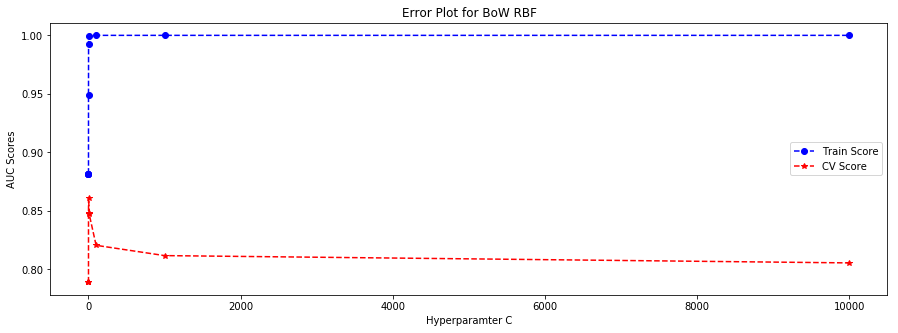

The CV AUC-score for each C value is :  [0.789 0.789 0.789 0.789 0.848 0.861 0.847 0.821 0.812 0.806]
the Train AUC score for each C value is :  [0.882 0.882 0.882 0.882 0.949 0.993 0.999 1.    1.    1.   ]


In [66]:

plt.figure(figsize=(15,5))
plt.xlabel('Hyperparamter C')
plt.ylabel('AUC Scores')
plt.title('Error Plot for BoW RBF')
# mean_train_score is to get mean value of all the error scores we got during cross validation
# cv_results_  = returns a dictionary of all the evaluation metrics from the gridsearch
plt.plot(model_rbf.cv_results_['param_C'].data.astype(np.float64), model_rbf.cv_results_['mean_train_score'], 
         linestyle='--', marker='o', color='b', label='Train Score')
plt.plot(model_rbf.cv_results_['param_C'].data.astype(np.float64), model_rbf.cv_results_['mean_test_score'], 
         linestyle='--', marker='*', color='r', label='CV Score')
plt.legend()
plt.show()

print("The CV AUC-score for each C value is : ", np.round(model_rbf.cv_results_['mean_test_score'],3))

print("the Train AUC score for each C value is : ", np.round(model_rbf.cv_results_['mean_train_score'],3))


### 5.5 Plotting ROC curve and finding AUC score for BoW RBF Kernel

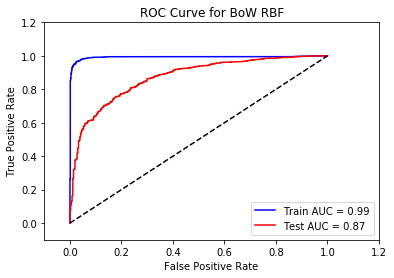

In [67]:
# ROC curve and AUC for BoW
from sklearn.metrics import roc_curve, auc
# Predicting the probabilities of test data as ROC curve needs probabilities to plot
Y_prob_rbf = model_rbf.fit(X_train_rbf_bow_std, Y_train_rbf)

train_fpr, train_tpr, thresholds = roc_curve(Y_train_rbf, Y_prob_rbf.predict_proba(X_train_rbf_bow_std)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test_rbf, Y_prob_rbf.predict_proba(X_test_rbf_bow_std)[:,1])

# Giving actual values(Y_test) and predicted probabilities Y_prob
# we need to calculate the fpr and tpr for all thresholds of the classification 

# We calculate the AUC (Area Under Curve)
roc_auc_train = auc(train_fpr, train_tpr)
roc_auc_test = auc(test_fpr, test_tpr)
    
# Plot FPR (on x-axis) v/s TPR (on y-axis)
plt.title('ROC Curve for BoW RBF')
plt.plot(train_fpr, train_tpr, 'b', label='Train AUC = %0.2f'% roc_auc_train)
plt.plot(test_fpr, test_tpr, 'r', label='Test AUC = %0.2f'% roc_auc_test)

plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'k--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Observation:-

From the ROC plot, we got the Train AUC of 0.98 and test AUC of 0.88, which shows that the classifier is working well and predicts correctly.


### 5.6 Confusion matrix for BoW RBF Kernel Train data

In [68]:
# Confusion matrix for Train data
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
pred_bow_train = rbf_optimal.predict(X_train_rbf_bow_std)
cm = confusion_matrix(Y_train_rbf, pred_bow_train)
print(cm)

Train confusion matrix
[[ 297  474]
 [   0 6229]]


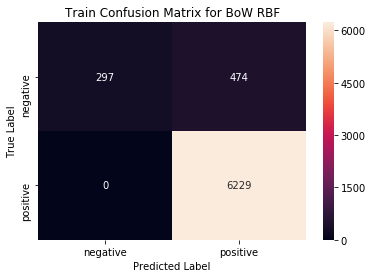

In [69]:
# plot confusion matrix for BoW Train data
class_label = ["negative", "positive"] # create a class label for columns and rows
cm = confusion_matrix(Y_train_rbf, pred_bow_train) 
dataframe_cm = pd.DataFrame(cm, index = class_label, columns = class_label) # create a dataframe to plot confusion matrix
# A heatmap is a two-dimensional graphical representation of data in seaborn,
# where the individual values in a matrix are represented with colors.
sns.heatmap(dataframe_cm, annot = True, fmt = "d") # annot=true means, write the data value in each cell
plt.title("Train Confusion Matrix for BoW RBF")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### 5.7 Confusion matrix for BoW RBF Kernel Test data

In [70]:
# Using confusion matrix as a another metric to measure accuracy
from sklearn.metrics import confusion_matrix
print("Test confusion matrix")
pred_bow_test = rbf_optimal.predict(X_test_rbf_bow_std)
cm = confusion_matrix(Y_test_rbf, pred_bow_test) # finding confusion matrix between true data and predicted data
print(cm)

Test confusion matrix
[[   9  352]
 [   4 2635]]


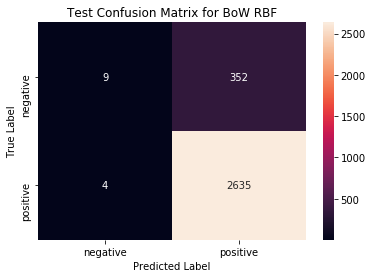

In [71]:
# plot confusion matrix for BoW RBF
class_label = ["negative", "positive"] # create a class label for columns and rows
cm = confusion_matrix(Y_test_rbf, pred_bow_test) 
dataframe_cm = pd.DataFrame(cm, index = class_label, columns = class_label) # create a dataframe to plot confusion matrix
# A heatmap is a two-dimensional graphical representation of data in seaborn,
# where the individual values in a matrix are represented with colors.
sns.heatmap(dataframe_cm, annot = True, fmt = "d") # annot=true means, write the data value in each cell
plt.title("Test Confusion Matrix for BoW RBF")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Observations:-

A Confusion matrix is a table that is often used to describe the performance of the classification model on a set of test data. It is also one of the metric to measure accuracy of the model.

A confusion matrix is a summary of prediction results on a classification problem. The number of correct and incorrect predictions are summarized with count values and broken down by each class. The confusion matrix shows how the classification model is confused when it makes predictions.

The above confusion matrix is didvided into 2 classes positive and negative with True values and predicted values.

TN - 9      FP - 352

FN - 4 ,    TP - 2635

where

TN - True negative, True value is negative, and is predicted value is negative.
FP - False positive, True value is negative, but is predicted as positive.
FN - False negative, True value is positive, but is predicted as negative
TP - True positive, True value is positive, and is predicted value is positive.

1. There are total of 3000 points being tested against the model. Out of all values, the classifier/model predicted points as positive 2987 times and negative 13 times.
2. But in true values(test data), the positive points are 2639 and negative points are 361.
3. The diagonal values (9 negative points, 2635 positive points) in the confusion matrix are correctly predicted values by the classifier.



#### Finding TPR, FPR, TNR, FNR values

1.  TPR tells, when it's actually yes and how often does classifier predict yes

    TPR = TP/(TP+FN) . TPR also known as Recall


2.  FPR tells, when it's actually no, how often does classifier predict yes

    FPR = FP/(FP+TN) 


3.  TNR tells, when it's actually no, how often does classifier predict no

    TNR = TN/(TN+FP)


4.  FNR tells, When it's actually yes, how often does it predict no

    FNR = FN/(FN+TP) 


### 5.7  Classification report for BoW RBF Kernel:-



1.  Classification Rate/Accuracy:

    Accuracy = (TP + TN) / (TP + TN + FP + FN)


2.  Recall:- It tells, when the points are positive and how often they are predicted positive.

    Recall = TP / (TP + FN)


3.  Precision:- It tells, when the model predicted positive and how often is it correct.

    Precision = TP / (TP + FP)


4.  f1-score = (2 Recall Precision) / (Recall + Presision)


5.  Support is the total number of points in each class (positive and negative)


In [72]:
# calculate the classification report for BoW
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score

print('Accuracy Score:', accuracy_score(Y_test_rbf, pred_bow_rbf)) 
print('Report:')
print(classification_report(Y_test_rbf, pred_bow_rbf)) 


Accuracy Score: 0.8813333333333333
Report:
             precision    recall  f1-score   support

          0       0.69      0.02      0.05       361
          1       0.88      1.00      0.94      2639

avg / total       0.86      0.88      0.83      3000



# 6.  TF-IDF

In [73]:
# TF-IDF
# in Scikit-learn
# tf_idf_vect is a variable created 
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df = 10, max_features = 500) # 1=unigrams, 2=bi-grams

# 'final_tf_idf' is the sparse matrix in which all of the tf-idf values are stored. 
# fit_transform is a function
X_train_rbf_tfidf = tf_idf_vect.fit_transform(X_train_rbf)
X_test_rbf_tfidf = tf_idf_vect.transform(X_test_rbf)

print("the type of TFIDF vectorizer ",type(X_train_rbf_tfidf))
print("the type of TFIDF vectorizer ",type(X_test_rbf_tfidf))

print(X_train_rbf_tfidf.get_shape())
print(X_test_rbf_tfidf.get_shape())

print("the number of unique words ", X_train_rbf_tfidf.get_shape()[1])
print("the number of unique words ", X_test_rbf_tfidf.get_shape()[1])


the type of TFIDF vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the type of TFIDF vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
(7000, 500)
(3000, 500)
the number of unique words  500
the number of unique words  500


#### Standardizing the data

In [74]:
from sklearn.preprocessing import StandardScaler
# Standardize the data
scalar = StandardScaler(with_mean=False)
X_train_tfidf_std = scalar.fit_transform(X_train_rbf_tfidf)
X_test_tfidf_std = scalar.transform(X_test_rbf_tfidf)

print("Final shape of matrix", X_train_tfidf_std.shape)
print("Final shape of matrix", X_test_tfidf_std.shape)


Final shape of matrix (7000, 500)
Final shape of matrix (3000, 500)


In [76]:
# get_feature_names() function is used to get feature names and all are stored in a variable called 'features'
features = tf_idf_vect.get_feature_names()
len(features)

500

In [77]:
print("some sample features(unique words in the corpus) are:")
features[50:60]

some sample features(unique words in the corpus) are:


['bread',
 'breakfast',
 'brew',
 'brown',
 'butter',
 'buy',
 'buying',
 'caffeine',
 'cake',
 'called']

In [78]:
def top_tfidf_feats(row, features, top_n=20):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]   # argsort sorts the top 20 tf-idf words for a given review
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

# vector 1 corresponding to review 1 and converting it into a numpy array and giving all feature values and prints the top 20 tf-idf values
top_tfidf = top_tfidf_feats(X_train_tfidf_std[1,:].toarray()[0],features,20)

In [79]:
top_tfidf

,feature,tfidf
0,soup,11.179032
1,chicken,8.291775
2,microwave,7.777456
3,cooking,6.687837
4,mouth,6.047835
5,noodles,4.739543
6,thing,4.601858
7,long,4.378784
8,different,4.254256
9,hard,3.710501


##  Implementing RBF Kernel using SVC on TF-IDF

### [6.1]  Performing GridSearchCV with RBF SVC on TF-IDF using  auc-score as metric 

In [80]:

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# GridsearchCV trains the model on these parmters to find the best one
# List of parameters for hyperparameter tuning
tuned_parameters = {'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

svc_clf = SVC(kernel = 'rbf', probability=True, class_weight = 'balanced')

model_rbf = GridSearchCV(svc_clf, tuned_parameters, scoring = 'roc_auc', n_jobs = -1, cv=5)
model_rbf.fit(X_train_tfidf_std , Y_train_rbf)

print("Model with best parameters is :\n", model_rbf.best_estimator_)

optimal_C = model_rbf.best_estimator_.C
print("The optimal value of C is:", optimal_C)

Model with best parameters is :
 SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
The optimal value of C is: 1


In [81]:
# get the score on test data 
print(model_rbf.score(X_test_tfidf_std , Y_test_rbf))  


0.8736473670564796


### [6.2] Predicting Test score and Test error for TF-IDF RBF Kernel

In [82]:
# Predicting model on test data to find AUC-score 
from sklearn.metrics import roc_auc_score

rbf_optimal = SVC(C = optimal_C)

# fitting the model
rbf_optimal.fit(X_train_tfidf_std, Y_train_rbf)

# predict the response
pred_tfidf_rbf = rbf_optimal.predict(X_test_tfidf_std)

# evaluate accuracy. Using AUC_score as metric to measure accuracy, , average = 'weighted'
test_tfidf_rbf = roc_auc_score(Y_test_rbf, pred_tfidf_rbf) * float(100)
print('\nThe test AUC-score of the RBF kernel TFIDF for optimal hyperparameters is %f%%' % (test_tfidf_rbf))




The test AUC-score of the RBF kernel TFIDF for optimal hyperparameters is 52.832801%


In [83]:
# Finding test error
test_error_tfidf = (1 - roc_auc_score(Y_test_rbf, pred_tfidf_rbf)) 
print("Test Error for SGDclassifier TF-IDF RBF is %.3f%%" % (test_error_tfidf))

Test Error for SGDclassifier TF-IDF RBF is 0.472%


### [6.3]   Plotting the performance of Train and CV scores for TF-IDF

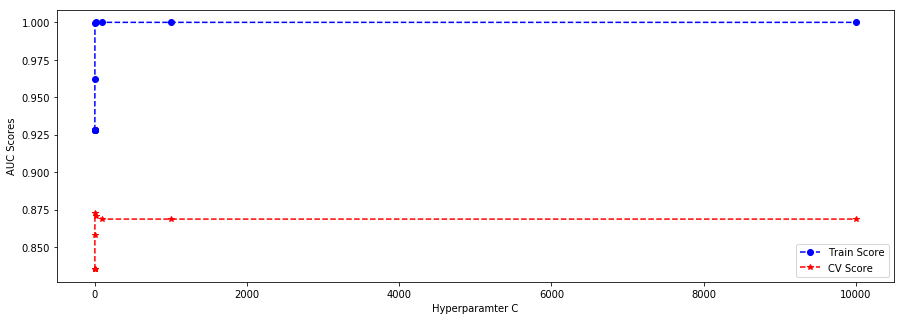

The CV AUC-score for each C value is :  [0.835 0.835 0.835 0.835 0.858 0.873 0.871 0.869 0.869 0.869]
the Train AUC score for each C value is :  [0.928 0.928 0.928 0.928 0.962 1.    1.    1.    1.    1.   ]


In [84]:
plt.figure(figsize=(15,5))
plt.xlabel('Hyperparamter C')
plt.ylabel('AUC Scores')
# mean_train_score is to get mean value of all the error scores we got during cross validation
# cv_results_  = returns a dictionary of all the evaluation metrics from the gridsearch
plt.plot(model_rbf.cv_results_['param_C'].data.astype(np.float64), model_rbf.cv_results_['mean_train_score'], 
         linestyle='--', marker='o', color='b', label='Train Score')
plt.plot(model_rbf.cv_results_['param_C'].data.astype(np.float64), model_rbf.cv_results_['mean_test_score'], 
         linestyle='--', marker='*', color='r', label='CV Score')
plt.legend()
plt.show()

print("The CV AUC-score for each C value is : ", np.round(model_rbf.cv_results_['mean_test_score'],3))

print("the Train AUC score for each C value is : ", np.round(model_rbf.cv_results_['mean_train_score'],3))


### [6.4]  Plotting ROC curve and finding AUC score for TFIDF

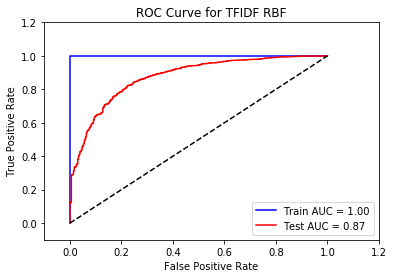

In [85]:
# ROC curve and AUC for TFIDF
from sklearn.metrics import roc_curve, auc
# Predicting the probabilities of test data as ROC curve needs probabilities to plot
Y_prob_rbf = model_rbf.fit(X_train_tfidf_std, Y_train_rbf)

train_fpr, train_tpr, thresholds = roc_curve(Y_train_rbf, Y_prob_rbf.predict_proba(X_train_tfidf_std)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test_rbf, Y_prob_rbf.predict_proba(X_test_tfidf_std)[:,1])

# Giving actual values(Y_test) and predicted probabilities Y_prob
# we need to calculate the fpr and tpr for all thresholds of the classification 

# We calculate the AUC (Area Under Curve)
roc_auc_train = auc(train_fpr, train_tpr)
roc_auc_test = auc(test_fpr, test_tpr)
    
# Plot FPR (on x-axis) v/s TPR (on y-axis)
plt.title('ROC Curve for TFIDF RBF')
plt.plot(train_fpr, train_tpr, 'b', label='Train AUC = %0.2f'% roc_auc_train)
plt.plot(test_fpr, test_tpr, 'r', label='Test AUC = %0.2f'% roc_auc_test)

plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'k--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### [6.5] Confusion matrix for TFIDF RBF Train data

In [86]:
# Confusion matrix for Train data
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
pred_tfidf_train = rbf_optimal.predict(X_train_tfidf_std)
cm = confusion_matrix(Y_train_rbf, pred_tfidf_train)
print(cm)

Train confusion matrix
[[ 415  356]
 [   2 6227]]


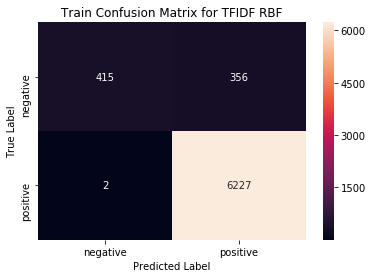

In [87]:
# plot confusion matrix for TFIDF Train data
class_label = ["negative", "positive"] # create a class label for columns and rows
cm = confusion_matrix(Y_train_rbf, pred_tfidf_train) 
dataframe_cm = pd.DataFrame(cm, index = class_label, columns = class_label) # create a dataframe to plot confusion matrix
# A heatmap is a two-dimensional graphical representation of data in seaborn,
# where the individual values in a matrix are represented with colors.
sns.heatmap(dataframe_cm, annot = True, fmt = "d") # annot=true means, write the data value in each cell
plt.title("Train Confusion Matrix for TFIDF RBF")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### 6.6 Confusion matrix for TFIDF RBF Test data

In [88]:
# Using confusion matrix as a another metric to measure accuracy
from sklearn.metrics import confusion_matrix
print("Test confusion matrix")
pred_tfidf_test = rbf_optimal.predict(X_test_tfidf_std)
cm = confusion_matrix(Y_test_rbf, pred_tfidf_test) # finding confusion matrix between true data and predicted data
print(cm)

Test confusion matrix
[[  21  340]
 [   4 2635]]


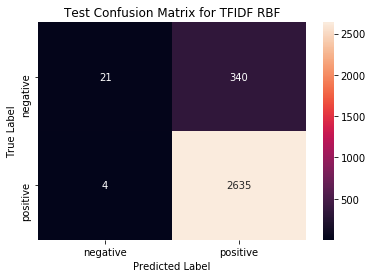

In [89]:
# plot confusion matrix for TFIDF
class_label = ["negative", "positive"] # create a class label for columns and rows
cm = confusion_matrix(Y_test_rbf, pred_tfidf_test) 
dataframe_cm = pd.DataFrame(cm, index = class_label, columns = class_label) # create a dataframe to plot confusion matrix
# A heatmap is a two-dimensional graphical representation of data in seaborn,
# where the individual values in a matrix are represented with colors.
sns.heatmap(dataframe_cm, annot = True, fmt = "d") # annot=true means, write the data value in each cell
plt.title("Test Confusion Matrix for TFIDF RBF")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### [6.6]   Classification report for TFIDF:-

1. Classification Rate/Accuracy:

   Accuracy = (TP + TN) / (TP + TN + FP + FN)
   

2. Recall:- It tells, when the points are positive and how often they are predicted positive.

   Recall = TP / (TP + FN)
   

3. Precision:- It tells, when the model predicted positive and how often is it correct.

   Precision = TP / (TP + FP)
   

4. f1-score = (2 Recall Precision) / (Recall + Presision)


5. Support is the total number of points in each class (positive and negative)



In [90]:
# calculate the classification report for TFIDF
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score

print('Accuracy Score:', accuracy_score(Y_test_rbf, pred_tfidf_rbf)) 
print('Report:')
print(classification_report(Y_test_rbf, pred_tfidf_rbf)) 


Accuracy Score: 0.8853333333333333
Report:
             precision    recall  f1-score   support

          0       0.84      0.06      0.11       361
          1       0.89      1.00      0.94      2639

avg / total       0.88      0.89      0.84      3000



# 7.  Word2Vec

In [91]:
# I am Training Word2Vec model using Amazon fine food text corpus
# This is W2V for Train data
# We are creating a list of sentences
# list_of_sent is created to store sentences
i=0
list_of_sent_train=[]
for sent in X_train_rbf:
    list_of_sent_train.append(sent.split())

In [92]:
# One sentence is converted into a list
print(X_train_rbf.values[0])
print("*****************************************************************")
print(list_of_sent_train[0])

could not believe good nectar tastes expecting aftertaste bitter like artificial sweeteners pleasantly surprised first taste husband taste not like artificial sweeteners loved come handy perricone weight loss diet low glycemic index price case amazon really good stocking upif diabetic best tasting sweetener lowest glycemic index right
*****************************************************************
['could', 'not', 'believe', 'good', 'nectar', 'tastes', 'expecting', 'aftertaste', 'bitter', 'like', 'artificial', 'sweeteners', 'pleasantly', 'surprised', 'first', 'taste', 'husband', 'taste', 'not', 'like', 'artificial', 'sweeteners', 'loved', 'come', 'handy', 'perricone', 'weight', 'loss', 'diet', 'low', 'glycemic', 'index', 'price', 'case', 'amazon', 'really', 'good', 'stocking', 'upif', 'diabetic', 'best', 'tasting', 'sweetener', 'lowest', 'glycemic', 'index', 'right']


In [93]:
# Train the word2vec model for Train data
# min_count=5 says, if the word doesn't occur atleast 5 times then don't construct w2v for it
# size=50 says about the dimension of the vector
# we are storing Word2Vec model in w2v_model
import gensim
w2v_model_train = gensim.models.Word2Vec(list_of_sent_train, min_count=5, size=50, workers=4)

# we can get dictionary of all the words that we have
# we are storing Word2Vec model in w2v_model
words_train = list(w2v_model_train.wv.vocab)
print(len(words_train))

# prints 50 words
print("sample words ", words_train[0:50])

5315
sample words  ['could', 'not', 'believe', 'good', 'nectar', 'tastes', 'expecting', 'aftertaste', 'bitter', 'like', 'artificial', 'sweeteners', 'pleasantly', 'surprised', 'first', 'taste', 'husband', 'loved', 'come', 'handy', 'weight', 'loss', 'diet', 'low', 'glycemic', 'index', 'price', 'case', 'amazon', 'really', 'stocking', 'diabetic', 'best', 'tasting', 'sweetener', 'lowest', 'right', 'perhaps', 'microwave', 'cooking', 'long', 'two', 'different', 'types', 'soup', 'tried', 'chicken', 'noodles', 'rice', 'left']


In [94]:
w2v_model_train.wv.most_similar('family')

[('mother', 0.9976037740707397),
 ('diagnosed', 0.9974036812782288),
 ('birthday', 0.9973952770233154),
 ('ate', 0.9971481561660767),
 ('daughter', 0.9970908761024475),
 ('litter', 0.9969993233680725),
 ('died', 0.9969103932380676),
 ('living', 0.9969046711921692),
 ('girlfriend', 0.9968836903572083),
 ('worked', 0.9968229532241821)]

In [95]:
# This is W2V for Test data
# We are creating a list of sentences
# list_of_sent is created to store sentences
i=0
list_of_sent_test=[]
for sent in X_test_rbf:
    list_of_sent_test.append(sent.split())
    

In [96]:
# One sentence is converted into a list
print(X_test_rbf.values[0])
print("*****************************************************************")
print(list_of_sent_test[0])

finally gfcf granola stuff amazing got husband daughter gfcf love stuff truly not nuts seed person not stop eating happy able give daughter snack great protein easy eat husband going keep bag car snack
*****************************************************************
['finally', 'gfcf', 'granola', 'stuff', 'amazing', 'got', 'husband', 'daughter', 'gfcf', 'love', 'stuff', 'truly', 'not', 'nuts', 'seed', 'person', 'not', 'stop', 'eating', 'happy', 'able', 'give', 'daughter', 'snack', 'great', 'protein', 'easy', 'eat', 'husband', 'going', 'keep', 'bag', 'car', 'snack']


In [97]:
# Train the word2vec model for Test data
# min_count=5 says, if the word doesn't occur atleast 5 times then don't construct w2v for it
# size=50 says about the dimension of the vector
# we are storing Word2Vec model in w2v_model
import gensim
w2v_model_test = gensim.models.Word2Vec(list_of_sent_test, min_count=5, size=50, workers=4)

# we can get dictionary of all the words that we have
# we are storing Word2Vec model in w2v_model
words_test = list(w2v_model_test.wv.vocab)
print(len(words_test))

# prints 50 words
print("sample words ", words_test[0:50])

3185
sample words  ['finally', 'gfcf', 'granola', 'stuff', 'amazing', 'got', 'husband', 'daughter', 'love', 'truly', 'not', 'nuts', 'seed', 'person', 'stop', 'eating', 'happy', 'able', 'give', 'snack', 'great', 'protein', 'easy', 'eat', 'going', 'keep', 'bag', 'car', 'purchased', 'bar', 'along', 'almond', 'bars', 'purchase', 'tried', 'far', 'superior', 'liked', 'pure', 'imported', 'chocolate', 'past', 'go', 'back', 'nothing', 'comes', 'close', 'rich', 'taste', 'texture']


In [98]:
w2v_model_test.wv.most_similar('like')

[('enjoy', 0.9996379613876343),
 ('nice', 0.9996223449707031),
 ('delicious', 0.9996110200881958),
 ('strong', 0.9996069073677063),
 ('texture', 0.999596893787384),
 ('rich', 0.9995772838592529),
 ('wonderful', 0.999565839767456),
 ('flavor', 0.999553382396698),
 ('sweet', 0.9995436668395996),
 ('also', 0.9995402693748474)]

In [99]:
# list of words in BoW
count_vect_feat = count_vect.get_feature_names()
print(len(count_vect_feat))

500


## [7.1] Avg-Word2Vec

We take the average of all word2vec(vector) representations of all words in a review and divide them by number of words in a review. This is vector representation of a review. 

### Average Word2Vec for Train data

In [100]:
# average Word2Vec for Train data
# compute average word2vec for each review.
from tqdm import tqdm
#List to store all the avg w2vec's 
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # to count num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in words_train:
            vec = w2v_model_train.wv[word] # vector of each word using w2v model
            sent_vec += vec # Adding the vectors
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words  # Taking average of vectors sum of the particular review
    sent_vectors_train.append(sent_vec)  # Storing the avg w2vec's for each review in the list
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

7000
50


### Average Word2Vec for Test data

In [101]:
# average Word2Vec for Test data
# compute average word2vec for each review.
from tqdm import tqdm
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in words_test:
            vec = w2v_model_test.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

3000
50


### [7.2] Performing RBF SVC using GridSearch CV on AvgW2V using AUC-score as metric

In [102]:
#  Implementing SVC

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# GridsearchCV trains the model on these parmters to find the best one
# List of parameters for hyperparameter tuning
tuned_parameters = {'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
svc_clf = SVC(kernel = 'rbf', probability=True, class_weight = 'balanced')
model_rbf = GridSearchCV(svc_clf, tuned_parameters, scoring = 'roc_auc', n_jobs = -1, cv=5)
model_rbf.fit(sent_vectors_train , Y_train_rbf)

print("Model with best parameters is :\n", model_rbf.best_estimator_)

optimal_C = model_rbf.best_estimator_.C
print("The optimal value of C is:", optimal_C)

Model with best parameters is :
 SVC(C=10000, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
The optimal value of C is: 10000


In [104]:
# get the score on test data 
print(model_rbf.score(sent_vectors_test, Y_test_rbf))  


0.5043272707806092


### 7.3 Predicting Test score and Test error

In [105]:
# Predicting model on test data to find AUC -score for RBF
from sklearn.metrics import roc_auc_score

rbf_optimal = SVC(C = optimal_C)

# fitting the model
rbf_optimal.fit(sent_vectors_train, Y_train_rbf)

# predict the response
pred_w2v = rbf_optimal.predict(sent_vectors_test)

# evaluate accuracy. 
test_w2v = roc_auc_score(Y_test_rbf, pred_w2v) * float(100)
print('\nThe test AUC-score of the RBF Kernel AVGW2V for optimal hyperparameters is %f%%' % (test_w2v))




The test AUC-score of the RBF Kernel AVGW2V for optimal hyperparameters is 50.000000%


In [106]:
# Finding test error
test_error_w2v = (1 - roc_auc_score(Y_test_rbf, pred_w2v))
print("Test Error for RBF Kernel AVGW2V is %.3f%%" % (test_error_w2v))

Test Error for RBF Kernel AVGW2V is 0.500%


### 7.4  Plotting the performance of Train and CV scores for AvgW2V

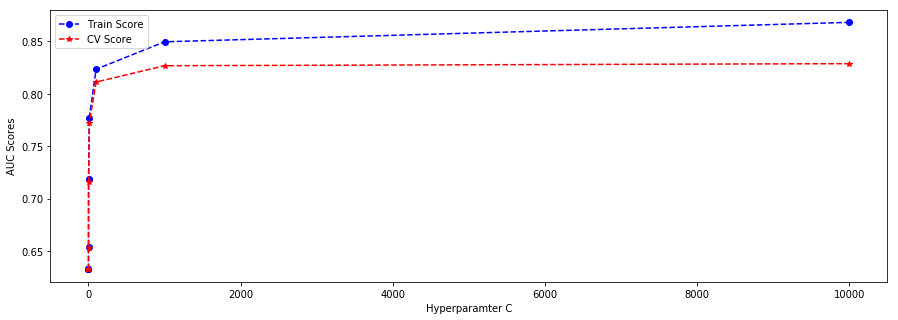

The CV AUC-score for each C value is :  [0.633 0.633 0.633 0.633 0.653 0.716 0.772 0.811 0.827 0.829]
the Train AUC score for each C value is :  [0.633 0.633 0.633 0.633 0.654 0.718 0.777 0.823 0.85  0.868]


In [107]:
plt.figure(figsize=(15,5))
plt.xlabel('Hyperparamter C')
plt.ylabel('AUC Scores')
# mean_train_score is to get mean value of all the error scores we got during cross validation
# cv_results_  = returns a dictionary of all the evaluation metrics from the gridsearch
plt.plot(model_rbf.cv_results_['param_C'].data.astype(np.float64), model_rbf.cv_results_['mean_train_score'], 
         linestyle='--', marker='o', color='b', label='Train Score')
plt.plot(model_rbf.cv_results_['param_C'].data.astype(np.float64), model_rbf.cv_results_['mean_test_score'], 
         linestyle='--', marker='*', color='r', label='CV Score')
plt.legend()
plt.show()

print("The CV AUC-score for each C value is : ", np.round(model_rbf.cv_results_['mean_test_score'],3))

print("the Train AUC score for each C value is : ", np.round(model_rbf.cv_results_['mean_train_score'],3))


###  7.5 Plotting ROC curve and finding AUC score for AvgW2V

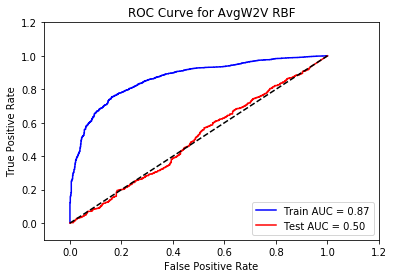

In [108]:
# ROC curve and AUC for AvgW2V
from sklearn.metrics import roc_curve, auc
# Predicting the probabilities of test data as ROC curve needs probabilities to plot
Y_prob_rbf = model_rbf.fit(sent_vectors_train, Y_train_rbf)

train_fpr, train_tpr, thresholds = roc_curve(Y_train_rbf, Y_prob_rbf.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test_rbf, Y_prob_rbf.predict_proba(sent_vectors_test)[:,1])

# Giving actual values(Y_test) and predicted probabilities Y_prob
# we need to calculate the fpr and tpr for all thresholds of the classification 

# We calculate the AUC (Area Under Curve)
roc_auc_train = auc(train_fpr, train_tpr)
roc_auc_test = auc(test_fpr, test_tpr)
    
# Plot FPR (on x-axis) v/s TPR (on y-axis)
plt.title('ROC Curve for AvgW2V RBF')
plt.plot(train_fpr, train_tpr, 'b', label='Train AUC = %0.2f'% roc_auc_train)
plt.plot(test_fpr, test_tpr, 'r', label='Test AUC = %0.2f'% roc_auc_test)

plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'k--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

###  7.6 Confusion matrix for AvgW2V RBF Kernel Train data

In [110]:
# Using confusion matrix as a another metric to measure accuracy
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
pred_w2v_train = rbf_optimal.predict(sent_vectors_train)
cm = confusion_matrix(Y_train_rbf, pred_w2v_train) # finding confusion matrix between true data and predicted data
print(cm)

Train confusion matrix
[[   1  770]
 [   0 6229]]


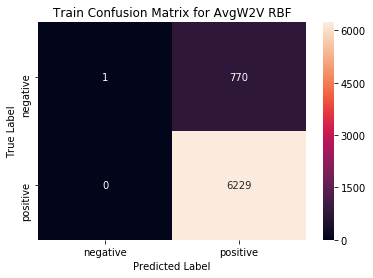

In [111]:
# plot confusion matrix for w2v 
class_label = ["negative", "positive"] # create a class label for columns and rows
cm = confusion_matrix(Y_train_rbf, pred_w2v_train) 
dataframe_cm = pd.DataFrame(cm, index = class_label, columns = class_label) # create a dataframe to plot confusion matrix
# A heatmap is a two-dimensional graphical representation of data in seaborn,
# where the individual values in a matrix are represented with colors.
sns.heatmap(dataframe_cm, annot = True, fmt = "d") # annot=true means, write the data value in each cell
plt.title("Train Confusion Matrix for AvgW2V RBF")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### 7.7 Confusion matrix for AvgW2V RBF Kernel Test data

In [112]:
from sklearn.metrics import confusion_matrix
print("Test confusion matrix")
pred_w2v_test = rbf_optimal.predict(sent_vectors_test)
cm = confusion_matrix(Y_test_rbf, pred_w2v_test) # finding confusion matrix between true data and predicted data
print(cm)

Test confusion matrix
[[   0  361]
 [   0 2639]]


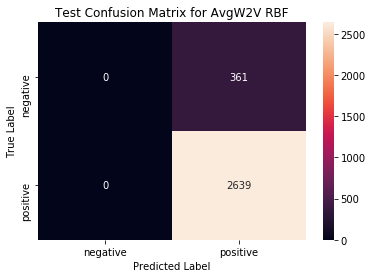

In [113]:
# plot confusion matrix for BoW RBF
class_label = ["negative", "positive"] # create a class label for columns and rows
cm = confusion_matrix(Y_test_rbf, pred_w2v_test) 
dataframe_cm = pd.DataFrame(cm, index = class_label, columns = class_label) # create a dataframe to plot confusion matrix
# A heatmap is a two-dimensional graphical representation of data in seaborn,
# where the individual values in a matrix are represented with colors.
sns.heatmap(dataframe_cm, annot = True, fmt = "d") # annot=true means, write the data value in each cell
plt.title("Test Confusion Matrix for AvgW2V RBF")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

###  7.8 Classification report for AvgW2V:-

  

In [114]:
# calculate the classification report for AvgW2V
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score

print('Accuracy Score:', accuracy_score(Y_test_rbf, pred_w2v)) 
print('Report:')
print(classification_report(Y_test_rbf, pred_w2v)) 


Accuracy Score: 0.8796666666666667
Report:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       361
          1       0.88      1.00      0.94      2639

avg / total       0.77      0.88      0.82      3000



# 8. TFIDF-W2V

###  8.1 RBF Kernel for TFIDF-W2V

In [115]:
model = TfidfVectorizer()
tfidf_train_matrix_rbf = model.fit_transform(X_train_rbf)
tfidf_test_matrix_rbf = model.transform(X_test_rbf)

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))


In [116]:
print(tfidf_train_matrix_rbf.get_shape()) 
print(tfidf_test_matrix_rbf.get_shape()) 


(7000, 23610)
(3000, 23610)


### 8.2 TFIDF-W2V for Train data

In [117]:
# TF-IDF weighted Word2Vec for Train data

tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train_rbf = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in words_train:
            try:
                vec = w2v_model_train.wv[word]
            # tf_idf = tfidf_train_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
            except:
                pass
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train_rbf.append(sent_vec)
    row += 1

100%|██████████| 7000/7000 [00:22<00:00, 307.44it/s]


### 8.3 TFIDF-W2V for Test data

In [118]:
# TF-IDF weighted Word2Vec for Test data

tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test_rbf = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in words_test:
            try:
                vec = w2v_model_test.wv[word]
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            #tf_idf = tfidf_test_matrix[row, tfidf_feat.index(word)]
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
            except:
                pass
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test_rbf.append(sent_vec)
    row += 1

100%|██████████| 3000/3000 [00:06<00:00, 458.47it/s]


###  8.4  Applying GridSearchCV and RBF Kernel on TFIDF-W2V using AUC-score as metric

In [119]:
# Implementing RBF Kernel.
# C and gamma are the hyperparameters for RBF Kernel. gamma = 1/sigma
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# GridsearchCV trains the model on these parmters to find the best one
# List of parameters for hyperparameter tuning
tuned_parameters = {'C':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

#Now using GridSearchCV, RBF Kernel is trained on these list of hyperparameters/values of gamma.
# Scoring is taken as f1_macro.
# We have to take the kernel = rbf here, though we can take other kernels depending on requirement. 
# Here probability is taken as True beacause , we need to get probability scores to plot ROC curve and get AUC score. So
# predict_proba doesn't work if probability is false.

svc_clf = SVC(kernel = 'rbf', probability=True, class_weight = 'balanced')
model_rbf = GridSearchCV(svc_clf, tuned_parameters, scoring = 'roc_auc', n_jobs = -1, cv=5)
model_rbf.fit(tfidf_sent_vectors_train_rbf, Y_train_rbf)

print("Model with best parameters is :\n", model_rbf.best_estimator_)

optimal_C = model_rbf.best_estimator_.C
print("The optimal value of C is:", optimal_C)

Model with best parameters is :
 SVC(C=1000, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
The optimal value of C is: 1000


In [121]:
# get the score on test data 
print(model_rbf.score(tfidf_sent_vectors_test_rbf, Y_test_rbf))  


0.4619803732421938


### 8.5  Predicting Test score and Test error

In [123]:

from sklearn.metrics import roc_auc_score

rbf_optimal = SVC(C = optimal_C)

# fitting the model
rbf_optimal.fit(tfidf_sent_vectors_train_rbf, Y_train_rbf)

# predict the response
pred_tfidfw2v = rbf_optimal.predict(tfidf_sent_vectors_test_rbf)

# evaluate accuracy. Using AUC_score as metric to measure accuracy
test_tfidfw2v = roc_auc_score(Y_test_rbf, pred_tfidfw2v) * float(100)
print('\nThe test AUC-score of the RBF kernel TFIDF-W2V for optimal hyperparameters is %f%%' % (test_tfidfw2v))




The test AUC-score of the RBF kernel TFIDF-W2V for optimal hyperparameters is 50.000000%


In [124]:
# Finding test error
test_error_tfidfw2v = (1 - roc_auc_score(Y_test_rbf, pred_tfidfw2v))
print("Test Error for RBF Kernel TFIDF-W2V is %.3f%%" % (test_error_tfidfw2v))

Test Error for RBF Kernel TFIDF-W2V is 0.500%


### 8.6  Plotting the performance of Train and CV scores for RBF Kernel

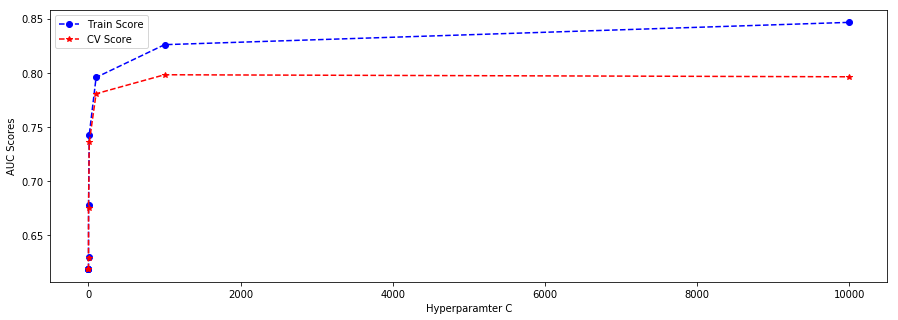

The CV AUC-score for each C value is :  [0.618 0.618 0.618 0.618 0.629 0.676 0.736 0.781 0.798 0.796]
the Train AUC score for each C value is :  [0.619 0.619 0.619 0.619 0.63  0.678 0.743 0.796 0.826 0.847]


In [125]:
plt.figure(figsize=(15,5))
plt.xlabel('Hyperparamter C')
plt.ylabel('AUC Scores')
# mean_train_score is to get mean value of all the error scores we got during cross validation
# cv_results_  = returns a dictionary of all the evaluation metrics from the gridsearch
plt.plot(model_rbf.cv_results_['param_C'].data.astype(np.float64), model_rbf.cv_results_['mean_train_score'], 
         linestyle='--', marker='o', color='b', label='Train Score')
plt.plot(model_rbf.cv_results_['param_C'].data.astype(np.float64), model_rbf.cv_results_['mean_test_score'], 
         linestyle='--', marker='*', color='r', label='CV Score')
plt.legend()
plt.show()

print("The CV AUC-score for each C value is : ", np.round(model_rbf.cv_results_['mean_test_score'],3))

print("the Train AUC score for each C value is : ", np.round(model_rbf.cv_results_['mean_train_score'],3))


### 8.7  Plotting ROC curve and finding AUC score for TFIDF-W2V RBF Kernel

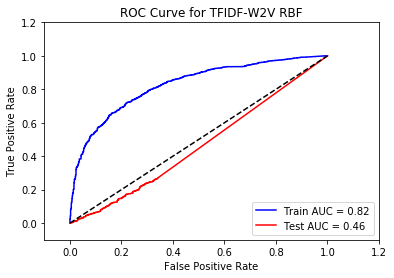

In [126]:
# ROC curve and AUC for TFIDF-W2V
from sklearn.metrics import roc_curve, auc
# Predicting the probabilities of test data as ROC curve needs probabilities to plot
Y_prob_rbf = model_rbf.fit(tfidf_sent_vectors_train_rbf, Y_train_rbf)

train_fpr, train_tpr, thresholds = roc_curve(Y_train_rbf, Y_prob_rbf.predict_proba(tfidf_sent_vectors_train_rbf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test_rbf, Y_prob_rbf.predict_proba(tfidf_sent_vectors_test_rbf)[:,1])

# Giving actual values(Y_test) and predicted probabilities Y_prob
# we need to calculate the fpr and tpr for all thresholds of the classification 

# We calculate the AUC (Area Under Curve)
roc_auc_train = auc(train_fpr, train_tpr)
roc_auc_test = auc(test_fpr, test_tpr)
    
# Plot FPR (on x-axis) v/s TPR (on y-axis)
plt.title('ROC Curve for TFIDF-W2V RBF')
plt.plot(train_fpr, train_tpr, 'b', label='Train AUC = %0.2f'% roc_auc_train)
plt.plot(test_fpr, test_tpr, 'r', label='Test AUC = %0.2f'% roc_auc_test)

plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'k--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### 8.8 Confusion matrix for TFIDF-W2V RBF Kernel Train data

In [127]:
# Confusion matrix for Train data
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
pred_tfidfw2v_train = rbf_optimal.predict(tfidf_sent_vectors_train_rbf)
cm = confusion_matrix(Y_train_rbf, pred_tfidfw2v_train)
print(cm)

Train confusion matrix
[[   0  771]
 [   0 6229]]


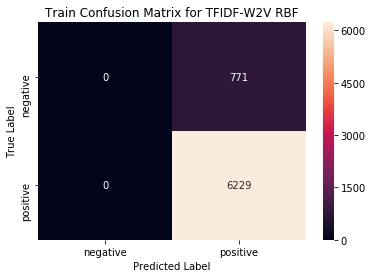

In [128]:
# plot confusion matrix for TFIDF-W2V Train data
class_label = ["negative", "positive"] # create a class label for columns and rows
cm = confusion_matrix(Y_train_rbf, pred_tfidfw2v_train) 
dataframe_cm = pd.DataFrame(cm, index = class_label, columns = class_label) # create a dataframe to plot confusion matrix
# A heatmap is a two-dimensional graphical representation of data in seaborn,
# where the individual values in a matrix are represented with colors.
sns.heatmap(dataframe_cm, annot = True, fmt = "d") # annot=true means, write the data value in each cell
plt.title("Train Confusion Matrix for TFIDF-W2V RBF")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### 8.9 Confusion matrix for TFIDF-W2V RBF Kernel Test data

In [129]:
# Using confusion matrix as a another metric to measure accuracy
from sklearn.metrics import confusion_matrix
print("Test confusion matrix")
pred_tfidfw2v_test = rbf_optimal.predict(tfidf_sent_vectors_test_rbf)
cm = confusion_matrix(Y_test_rbf, pred_tfidfw2v_test) # finding confusion matrix between true data and predicted data
print(cm)

Test confusion matrix
[[   0  361]
 [   0 2639]]


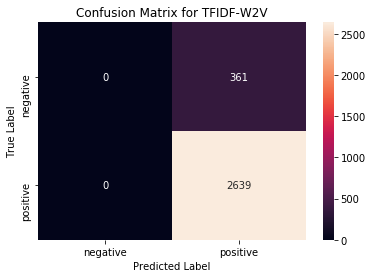

In [130]:
# plot confusion matrix for TFIDFW2V RBF
class_label = ["negative", "positive"] # create a class label for columns and rows
cm = confusion_matrix(Y_test_rbf, pred_tfidfw2v_test) 
dataframe_cm = pd.DataFrame(cm, index = class_label, columns = class_label) # create a dataframe to plot confusion matrix
# A heatmap is a two-dimensional graphical representation of data in seaborn,
# where the individual values in a matrix are represented with colors.
sns.heatmap(dataframe_cm, annot = True, fmt = "d") # annot=true means, write the data value in each cell
plt.title("Confusion Matrix for TFIDF-W2V")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### 8.10 Classification report for TFIDF-W2V RBF Kernel:-

  

In [131]:
# calculate the classification report for TFIDF-W2V
from sklearn.metrics import classification_report 
 
print('Accuracy Score:', accuracy_score(Y_test_rbf, pred_tfidfw2v)) 
print('Report:')
print(classification_report(Y_test_rbf, pred_tfidfw2v)) 


Accuracy Score: 0.8796666666666667
Report:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       361
          1       0.88      1.00      0.94      2639

avg / total       0.77      0.88      0.82      3000



## 9. Models Summarization

In [132]:
from pandas import DataFrame
RBF = {'Vectorizer':['BoW', 'TFIDF', 'AVG-W2V', 'TFIDF-W2V'], 'Model':['RBF Kernel','RBF Kernel','RBF Kernel','RBF Kernel'], 
                       'Hyper parameter C':['1','1','10000','1000'], 
                       'AUC score':['51.17','52.83','50.00','50.00'],
                       'Test error':['0.48','0.47','0.50','0.50'],
                       'Train AUC Score':['0.99','1.00','0.87','0.82'],
                       'Test AUC Score':['0.87','0.87','0.50','0.46']}
                       

In [133]:
Final_conclusions = DataFrame(RBF)
Final_conclusions

,Vectorizer,Model,Hyper parameter C,AUC score,Test error,Train AUC Score,Test AUC Score
0,BoW,RBF Kernel,1,51.17,0.48,0.99,0.87
1,TFIDF,RBF Kernel,1,52.83,0.47,1.00,0.87
2,AVG-W2V,RBF Kernel,10000,50.00,0.50,0.87,0.50
3,TFIDF-W2V,RBF Kernel,1000,50.00,0.50,0.82,0.46


## 10. Conclusions:-

1. From the above observations AUC score is better for BoW and TFIDF than other featurizations.
2. The train AUC score from ROC curve, are good for all featurizations. But the test AUC score is better for BoW and TFIDF.
3. Out of all 4 featurizations trained by RBF Kernel, BoW and TFIDF are working well on unseen data.

So finally, Linear SVM using SGDClassifier with hinge loss gave good results than RBF Kernel and it is working well on unseen data. 